##  U-net based with Boundary loss for COVID detection
* This kernel use Attention structure

* Boundary loss reference by this [GITHUB]( https://github.com/LIVIAETS/boundary-loss)

# * Let's see how it performs!!

# Read dicom files

In [1]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
import cv2
import tensorflow as tf

In [2]:
# Read and examine metadata
data = pd.read_csv('../input/covid19-ct-scans/metadata.csv')
data.sample(5)
data.head(3)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [3]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array)) #this data needs to rotate 90 degrees 
    return(array)

In [4]:
# Read sample
sample_ct = read_nii(data.loc[0,'ct_scan'])

In [5]:
print (sample_ct.shape)

(512, 512, 301)


# Check HU transform is done or not

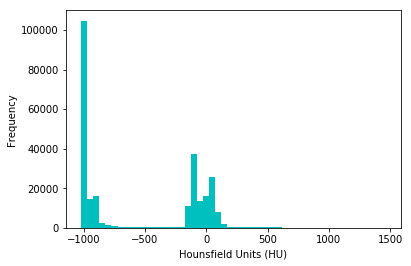

In [6]:

imgs_to_process = sample_ct[...,1]

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# No need to transform

In [7]:
CT = []
Mask = []
img_size = 128




for case in range(len(data)): #Concat all cases to list
    ct = read_nii(data['ct_scan'][case])
    mask = read_nii(data['infection_mask'][case])
    
    for imgsize in range(ct.shape[2]): #Convert pixals to 1-d array
        
        ct_img = cv2.resize(ct[..., imgsize], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        mask_img = cv2.resize(mask[..., imgsize],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        CT.append(ct_img[..., np.newaxis])
        Mask.append(mask_img[..., np.newaxis])

In [8]:
CT = np.array(CT)
Mask = np.array(Mask)

# Show data image

Text(0.5,1,'original infection mask')

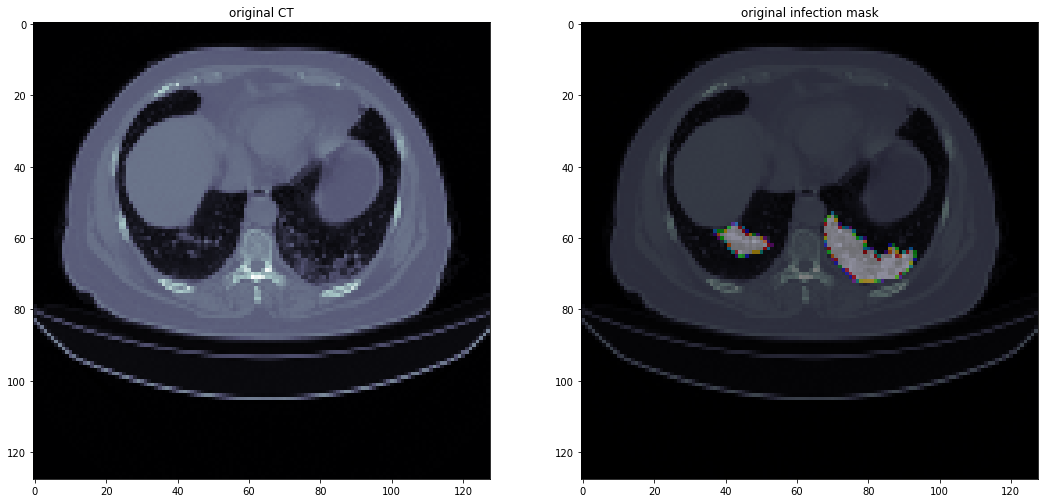

In [9]:
fig = plt.figure(figsize = (18,15))

plt.subplot(1,2,1)
plt.imshow(CT[100][...,0], cmap = 'bone')
plt.title('original CT')

plt.subplot(1,2,2)
plt.imshow(CT[100][...,0], cmap = 'bone')
plt.imshow(Mask[100][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')


# Now we have two choices, we could take lungs mask from CT as input or just use CT images

# This time I choose using CT directly 

# --------------------------------------------------

# Normalize pixel values in range [0,1] is a good idea before training

In [10]:
mins = CT.min(axis=(1,2,3), keepdims=True)
maxs = CT.max(axis=(1,2,3), keepdims=True)
norm_data = (CT-mins)/(maxs-mins)

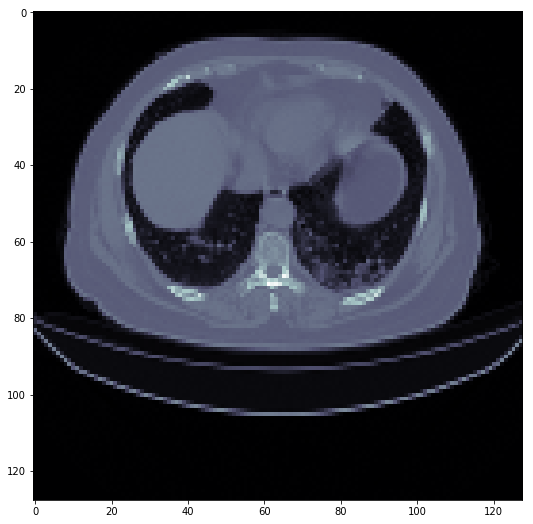

In [11]:
plt.figure(figsize = (9,9))

plt.imshow(norm_data[100][...,0], cmap = 'bone')

# Split into training and validation groups

In [12]:
from sklearn.model_selection import train_test_split
CT_train, CT_test, Mask_train, Mask_test = train_test_split(norm_data, Mask, test_size = 0.1)


# Build Attention Unet
Here we use a slight deviation on the U-Net standard

In [13]:
class attention_unet():
  def __init__(self,img_rows=128,img_cols=128):
    self.img_rows=img_rows
    self.img_cols=img_cols
    self.img_shape=(self.img_rows,self.img_cols,1)
    self.df=64
    self.uf=64
    
  def build_unet(self):
    def conv2d(layer_input,filters,dropout_rate=0,bn=False):
      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(layer_input)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)
      
      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(d)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)
      
      if dropout_rate:
        d=layers.Dropout(dropout_rate)(d)
      
      return d
    
    def deconv2d(layer_input,filters,bn=False):
      u=layers.UpSampling2D((2,2))(layer_input)
      u=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(u)
      if bn:
        u=layers.BatchNormalization()(u)
      u=layers.Activation('relu')(u)
      
      return u
    
    def attention_block(F_g,F_l,F_int,bn=False):
      g=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_g)
      if bn:
        g=layers.BatchNormalization()(g)
      x=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_l)
      if bn:
        x=layers.BatchNormalization()(x)
#       print(g.shape)
#       print(x.shape)
      psi=layers.Add()([g,x])
      psi=layers.Activation('relu')(psi)
      
      psi=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi)
      
      if bn:
        psi=layers.BatchNormalization()(psi)
      psi=layers.Activation('sigmoid')(psi)
      
      return layers.Multiply()([F_l,psi])
    
    inputs=layers.Input(shape=self.img_shape)
    
    conv1=conv2d(inputs,self.df)
    pool1=layers.MaxPooling2D((2,2))(conv1)
    
    conv2=conv2d(pool1,self.df*2,bn=True)
    pool2=layers.MaxPooling2D((2,2))(conv2)
    
    conv3=conv2d(pool2,self.df*4,bn=True)
    pool3=layers.MaxPooling2D((2,2))(conv3)
    
    conv4=conv2d(pool3,self.df*8,dropout_rate=0.5,bn=True)
    pool4=layers.MaxPooling2D((2,2))(conv4)
    
    conv5=conv2d(pool4,self.df*16,dropout_rate=0.5,bn=True)
    
    up6=deconv2d(conv5,self.uf*8,bn=True)
    conv6=attention_block(up6,conv4,self.uf*8,bn=True)
    up6=layers.Concatenate()([up6,conv6])
    conv6=conv2d(up6,self.uf*8)
    
    up7=deconv2d(conv6,self.uf*4,bn=True)
    conv7=attention_block(up7,conv3,self.uf*4,bn=True)
    up7=layers.Concatenate()([up7,conv7])
    conv7=conv2d(up7,self.uf*4)
    
    up8=deconv2d(conv7,self.uf*2,bn=True)
    conv8=attention_block(up8,conv2,self.uf*2,bn=True)
    up8=layers.Concatenate()([up8,conv8])
    conv8=conv2d(up8,self.uf*2)
    
    up9=deconv2d(conv8,self.uf,bn=True)
    conv9=attention_block(up9,conv1,self.uf,bn=True)
    up9=layers.Concatenate()([up9,conv9])
    conv9=conv2d(up9,self.uf)
    
    outputs=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(conv9)
    
    model=Model(inputs=inputs,outputs=outputs)
    
    return model


# In[29]:


from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model.model", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

Using TensorFlow backend.


# Define BatchNormalization

In [14]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import keras.layers as layers
from keras.models import Model



# batchnormalization
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
# block
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x
# residual_block
def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x


# Loss functions

In [15]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [16]:
from keras.optimizers import Adam

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

# Implement of "Boundary loss for highly unbalanced segmentation"

In [17]:
from scipy.ndimage import distance_transform_edt as distance


def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    y_true_numpy = y_true
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)


def surface_loss_keras(y_true, y_pred):
    y_true_dist_map = tf.py_func(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)



In [18]:
from keras.callbacks import ModelCheckpoint, Callback


class AlphaScheduler(Callback):
  def init(self, alpha, update_fn):
    self.alpha = alpha
    self.update_fn = update_fn
  def on_epoch_end(self, epoch, logs=None):
    updated_alpha = self.update_fn(K.get_value(self.alpha))

alpha = K.variable(1, dtype='float32')

def update_alpha(value):
  return np.clip(value - 0.01, 0.01, 1)


## Define Loss function
 
# We should considering both boundary loss and weighted binary cross entropy dice loss

In [19]:
def gl_sl_wrapper(alpha):
    def gl_sl(y_true, y_pred):
        return alpha* weighted_bce_dice_loss(y_true, y_pred) +  (1-alpha)* surface_loss_keras(y_true, y_pred)
    return gl_sl

## Set Training Check Point

In [20]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/callbacks.py:1062: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


## Comiple model

In [21]:
Net=attention_unet()
unet=Net.build_unet()

unet.compile(loss=gl_sl_wrapper(alpha),
             optimizer=Adam(1e-4),
             metrics=[dice_coef, 'binary_accuracy'])

unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       activation_1[0][0]               
__________________________________________________________________________________________________
activation

## Start Training

In [22]:
history = unet.fit(CT_train, Mask_train, epochs = 50, validation_data = (CT_test, Mask_test),verbose=1,shuffle=True, callbacks=[checkpoint])

Train on 3168 samples, validate on 352 samples
Epoch 1/50
3168/3168 [==============================] - 50s 16ms/step - loss: 0.7805 - dice_coef: 0.1936 - binary_accuracy: 0.9852 - val_loss: 1.1549 - val_dice_coef: 0.3135 - val_binary_accuracy: 0.9913

Epoch 00001: val_dice_coef improved from -inf to 0.31349, saving model to model_weights.best.hdf5
Epoch 2/50
3168/3168 [==============================] - 37s 12ms/step - loss: 0.3751 - dice_coef: 0.5409 - binary_accuracy: 0.9924 - val_loss: 0.5088 - val_dice_coef: 0.4562 - val_binary_accuracy: 0.9938

Epoch 00002: val_dice_coef improved from 0.31349 to 0.45619, saving model to model_weights.best.hdf5
Epoch 3/50
3168/3168 [==============================] - 36s 12ms/step - loss: 0.2943 - dice_coef: 0.6493 - binary_accuracy: 0.9935 - val_loss: 0.2728 - val_dice_coef: 0.5482 - val_binary_accuracy: 0.9951

Epoch 00003: val_dice_coef improved from 0.45619 to 0.54816, saving model to model_weights.best.hdf5
Epoch 4/50
3168/3168 [================

3168/3168 [==============================] - 37s 12ms/step - loss: 0.0973 - dice_coef: 0.9170 - binary_accuracy: 0.9958 - val_loss: 0.1572 - val_dice_coef: 0.8218 - val_binary_accuracy: 0.9960

Epoch 00030: val_dice_coef did not improve from 0.88981
Epoch 31/50
3168/3168 [==============================] - 37s 12ms/step - loss: 0.0957 - dice_coef: 0.9178 - binary_accuracy: 0.9958 - val_loss: 0.1481 - val_dice_coef: 0.8915 - val_binary_accuracy: 0.9962

Epoch 00031: val_dice_coef improved from 0.88981 to 0.89151, saving model to model_weights.best.hdf5
Epoch 32/50
3168/3168 [==============================] - 37s 12ms/step - loss: 0.0943 - dice_coef: 0.9208 - binary_accuracy: 0.9958 - val_loss: 0.1519 - val_dice_coef: 0.8883 - val_binary_accuracy: 0.9962

Epoch 00032: val_dice_coef did not improve from 0.89151
Epoch 33/50
3168/3168 [==============================] - 37s 12ms/step - loss: 0.0934 - dice_coef: 0.9208 - binary_accuracy: 0.9958 - val_loss: 0.1517 - val_dice_coef: 0.8660 - val_

In [40]:

unet.load_weights(weight_path)
unet.save('model.h5')


## Plot loss history

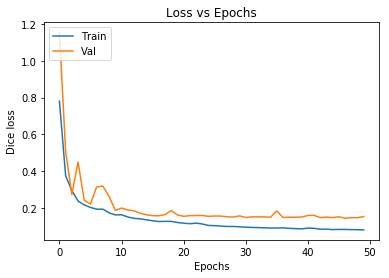

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice loss')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()


# Run the test data

Text(0.5,1,'predicted infection mask')

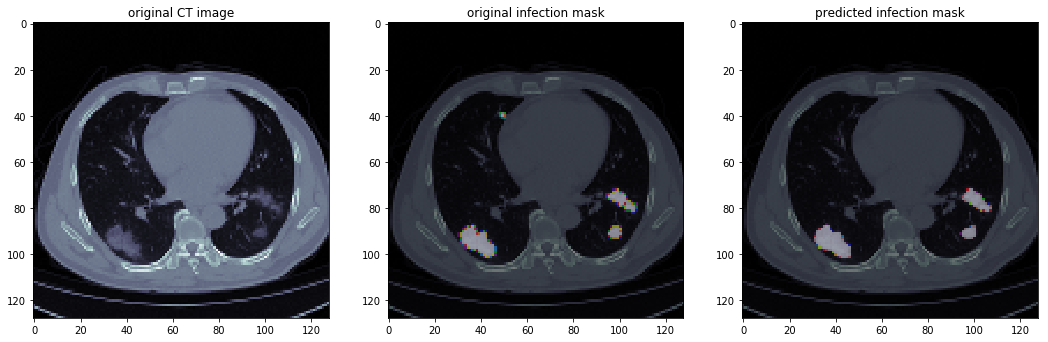

In [53]:
predicted = unet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[120][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[120][...,0], cmap = 'bone')
plt.imshow(Mask_test[120][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[120][...,0], cmap = 'bone')
plt.imshow(predicted[120][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')